2012- Robert M Dorazio & J. Andrew Royle. Estimating Size and Composition of Biological Communities by Modeling the occurrence of Species.
https://doi.org/10.1198/016214505000000015

Zero-inflated model

MacKenzie et al. 2006

MacKenzie et al. 2002

In [1]:
import shutil
import os
import zipfile
from joblib import dump, load
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch  # for legend patch
from scipy.optimize import minimize_scalar
from scipy.stats import norm, beta
from scipy.stats import binom


In [2]:
# Remove the directory and all its contents
if os.path.exists('MinduPark'):
    shutil.rmtree('MinduPark')
    print("Folder 'MinduPark' removed.")
if os.path.exists('MinduPark_without_sauim'):
    shutil.rmtree('MinduPark_without_sauim')
    print("Folder 'MinduPark_without_sauim' removed.")

## Ocumpacy modeling

Automatically download the necessary files

In [3]:
!wget https://github.com/juancolonna/Sauim/raw/main/MinduPark.zip -O MinduPark.zip
!wget https://github.com/juancolonna/Sauim/raw/main/MinduPark_without_sauim.zip -O MinduPark_without_sauim.zip
!wget https://github.com/juancolonna/Sauim/raw/main/ocsvm_filtered.joblib -O ocsvm_filtered.joblib

--2025-09-16 22:16:22--  https://github.com/juancolonna/Sauim/raw/main/MinduPark.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/juancolonna/Sauim/main/MinduPark.zip [following]
--2025-09-16 22:16:22--  https://media.githubusercontent.com/media/juancolonna/Sauim/main/MinduPark.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42146012 (40M) [application/zip]
Saving to: ‘MinduPark.zip’

MinduPark.zip       100%[===================>]  40.19M  31.1MB/s    in 1.3s    

2025-09-16 22:16:24 (31.1 MB/s) - ‘MinduPark.zip’ saved [42146012/42146012]

--2025-09-16 22:16:24--  https://

In [4]:
# Open and extract files
with zipfile.ZipFile('MinduPark.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

with zipfile.ZipFile('MinduPark_without_sauim.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

print(f'Files extracted')

Files extracted


In [5]:
clf = load("ocsvm_filtered.joblib")

Semples monitoring with Sauim occurrences

In [6]:
y = []
T = []
detections_per_record = []

for i in range(8):
    MinduPark_embedding_vectors = np.load("MinduPark/MinduPark_vectors_filtered_"+str(i)+".npy")
    decision_scores = clf.decision_function(MinduPark_embedding_vectors)
    MinduPark_preds = np.where(decision_scores >= 0, 1, 0)
    y.append(np.sum(MinduPark_preds == 1))
    T.append(len(MinduPark_preds))
    detections_per_record.append(MinduPark_preds)

y = np.array(y, dtype=int)
T = np.array(T, dtype=int)
print(y) # How many detections per record
print(T) # How many segments per record

[ 51   0   0  10 261  55  54 112]
[ 757  149  109  309 1036  360  419 1320]


In [7]:
detections = int(np.sum(y > 0))
detections

6

In [25]:
k = np.where(y>0, 1, 0)
K = np.ones(len(k), dtype=int)
eps = 1e-10

def loglike(p11):
    if p11 <= 0 or p11 >= 1:
        return -np.inf
    return float(binom.logpmf(k, K, p11).sum())

# MLE numérico (deve coincidir com a forma fechada)
res = minimize_scalar(lambda p11: -loglike(p11),
                      bounds=(eps, 1.0 - eps),
                      method="bounded")

print("p11^ (numérico):", res.x)
print("logLik no ótimo:", -res.fun)

p11^ (numérico): 0.2500000880971082
logLik no ótimo: -4.498681156950633


In [10]:
p01 = 1-res.x
p01

np.float64(0.2500000880968445)

In [21]:
p01_hi

[np.float64(1.0),
 np.float64(0.9919268446193276),
 np.float64(0.9030930388097743),
 np.float64(0.7961625905806612),
 np.float64(0.6767766952966369),
 np.float64(0.54616415428267),
 np.float64(0.40309321500351164),
 np.float64(0.24192665783888723),
 np.float64(0.0008691544556340433)]

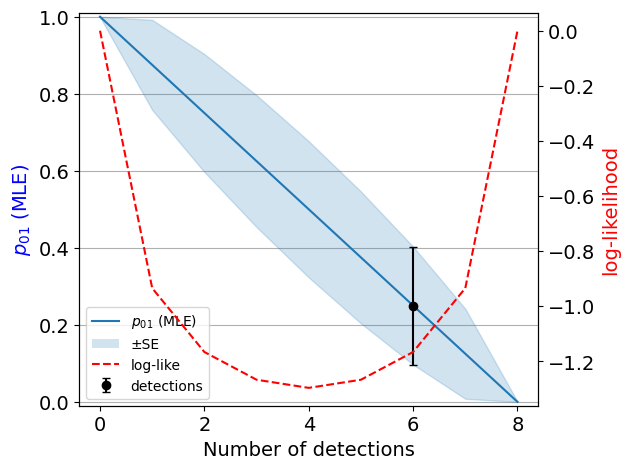

In [24]:
from scipy.stats import norm

K = len(y)
mle_p11 = []
mle_p01 = []
logLike = []
p01_lo = []   # SE-based lower band for w
p01_hi = []   # SE-based upper band for w

eps = 1e-12

for k in range(len(y)+1):
    def loglike(p11):
        if p11 <= 0 or p11 >= 1:
            return -np.inf
        return float(binom.logpmf(k, K, p11).sum())

    res = minimize_scalar(lambda p11: -loglike(p11), bounds=(0,1), method="bounded")
    p11_hat_k = res.x
    p01_hat_k = 1-p11_hat_k
    mle_p11.append(p11_hat_k)
    mle_p01.append(p01_hat_k)
    logLike.append(-res.fun)

    se_k = np.sqrt(p01_hat_k*(1-p01_hat_k)/K)

    lo = np.clip(p01_hat_k - se_k, 0.0, 1.0)
    hi = np.clip(p01_hat_k + se_k, 0.0, 1.0)

    p01_lo.append(lo)
    p01_hi.append(hi)

detections = int(np.sum(y > 0))

# --- plotting (unchanged except labels) ---
fig, ax1 = plt.subplots()
x = np.arange(len(mle_p01))

l1, = ax1.plot(x, mle_p01, label="$p_{01}$ (MLE)")
ax1.set_ylabel("$p_{01}$ (MLE)", color="blue", fontsize=14)
ax1.set_ylim(-0.01, 1.01)

band = ax1.fill_between(x, p01_lo, p01_hi, alpha=0.2, color=l1.get_color())
se_patch = Patch(facecolor=l1.get_color(), alpha=0.2, label=f"±SE")

y_hat_at_det = mle_p01[detections]
lo_at_det = p01_lo[detections]
hi_at_det = p01_hi[detections]
yerr_det = np.array([[y_hat_at_det - lo_at_det], [hi_at_det - y_hat_at_det]])
eb = ax1.errorbar([detections], [y_hat_at_det], yerr=yerr_det, fmt='o', color='black',
                  capsize=3, label="detections")

ax2 = ax1.twinx()
l2, = ax2.plot(x, logLike, label="log-like", color="red", linestyle="--")
ax2.set_ylabel("log-likelihood", color="red", fontsize=14)

ax1.set_xlabel("Number of detections", fontsize=14)
lines = [l1, se_patch, l2, eb]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="lower left")

# tamanho dos números dos eixos (tiques)
ax1.tick_params(axis='both', labelsize=14)  # x e y do ax1
ax2.tick_params(axis='y', labelsize=14)     # y do ax2 (direita)

fig.tight_layout()
ax1.grid(True, axis='y', which='both')
ax2.grid(False)
ax2.patch.set_visible(False)
ax1.set_axisbelow(True)

plt.savefig("likelihood_p01.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()
